## Figures

- Figure ST2 A,B,C,D
- Figure ST3 E,F

## Required files

- `models_dir / "model.results.finished.csv`
- `models_dir / 'dfi_subset.annotated.v3.parq`
- `models_dir / exp / f'deeplift/{t}/out/{experiments[exp]["imp_score"]}/modisco.h5'`
  - for all 6 models

## Produced files

`fdir = Path(f'{ddir}/figures/method-comparison/modisco')`

- Figure ST2 A
  - `fdir / 'auPRC.binary-vs-profile+binary.bar.pdf'`
- Figure ST2 B
  - `fdir / 'training-time.bar.pdf'`
- Figure ST2 C
  - `fdir / 'nexus.profile-vs-binary.motif-venn.heatmap.pdf'`
- Figure ST2 D
  - `fdir / 'profile-recall.nexus.profile-vs-binary.pdf'`
- Figure ST3 E
  - `fdir / 'nexus-vs-seq.motif-venn.heatmap.pdf'`
- Figure ST3 F
  - `fdir / 'profile-recall.nexus-vs-seq.pdf'`

In [10]:
from collections import OrderedDict
exp = 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE'
imp_score = 'profile/wn'

motifs = OrderedDict([
    ("Oct4-Sox2", 'Oct4/m0_p0'),
    ("Oct4", 'Oct4/m0_p1'),
    # ("Strange-sym-motif", 'Oct4/m0_p5'),
    ("Sox2", 'Sox2/m0_p1'),
    ("Nanog", 'Nanog/m0_p1'),
    ("Zic3", 'Nanog/m0_p2'),
    ("Nanog-partner", 'Nanog/m0_p4'),
    ("Klf4", 'Klf4/m0_p0'),
])

In [11]:
models = {
    'nexus/binary': 'nexus,gw,OSNK,1,0,0,FALSE,same,0.5,64,25,0.001,9,FALSE',
    'nexus/profile': 'nexus,peaks,OSNK,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE',
    'seq/profile': 'seq,peaks,OSN,0,10,1,FALSE,same,0.5,64,50,0.004,9,FALSE,[1,50],TRUE,TRUE',
    'seq/binary': 'seq,gw,OSN,1,0,0,FALSE,same,0.5,64,50,0.001,9,FALSE',
    'nexus/profile.peaks-union': 'nexus,nexus-seq-union,OSN,0,10,1,FALSE,same,0.5,64,25,0.004,9,FALSE,[1,50],TRUE,TRUE,0',
    'seq/profile.peaks-union': 'seq,nexus-seq-union,OSN,0,10,1,FALSE,same,0.5,64,50,0.004,9,FALSE,[1,50],TRUE,TRUE,0',
}
models_inv = {v:k for k,v in models.items()}

In [12]:
from basepair.imports import *
from basepair.exp.paper.config import *
from basepair.utils import flatten
from basepair.modisco.core import Pattern
from basepair.config import test_chr
from plotnine import *
import plotnine
from config import experiments
from basepair.utils import pd_first_cols, flatten
from basepair.exp.chipnexus.comparison import read_chexmix_dfi, read_meme_motifs, read_transfac
from basepair.plot.utils import plt9_tilt_xlab
from basepair.exp.paper.config import models_dir
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
paper_config()

import sys
sys.path.insert(0, '..')

In [13]:
fdir = Path(f'{ddir}/figures/method-comparison/modisco')
fdir.mkdir(exist_ok=True)

## Show which methods were evaluated on the same intervals

In [10]:
ranges_dict = {model: ImpScoreFile(models_dir / exp  /'deeplift.imp_score.h5', default_imp_score=experiments[exp]["imp_score"]).get_ranges()
               for model, exp in models.items()}

In [11]:
{k: len(v) for k,v in ranges_dict.items()}

{'nexus/binary': 147974,
 'nexus/profile': 147974,
 'seq/profile': 68042,
 'seq/binary': 68042,
 'nexus/profile.peaks-union': 55288,
 'seq/profile.peaks-union': 55288}

### Adding profile regression to binary classification model

In [14]:
exp = models['nexus/profile']

In [15]:
model_dir = models_dir / exp

In [ ]:
df_train = pd.read_csv(models_dir / "model.results.finished.csv")
df_train = df_train[df_train.exp.isin(models.values())]
df_train['exp_name'] = df_train.exp.map(models_inv)
gw_exp = ['nexus/binary', 'nexus/binary+profile']
dfp = df_train[df_train.exp_name.isin(gw_exp)][[f'valid-genome-wide/{task}/class/auPR' for task in tasks] + ['exp_name']].melt(id_vars='exp_name')
dfp['TF'] = dfp.variable.str.split("/", expand=True)[1]

dfp['TF'] = pd.Categorical(dfp['TF'], tasks)

In [15]:
colors = {"nexus/binary": "#EE8030",
          "nexus/profile": "#498AAD",
          "nexus/profile.gw": "#586BA4",
          "nexus/binary+profile": "#4E598C"
         }

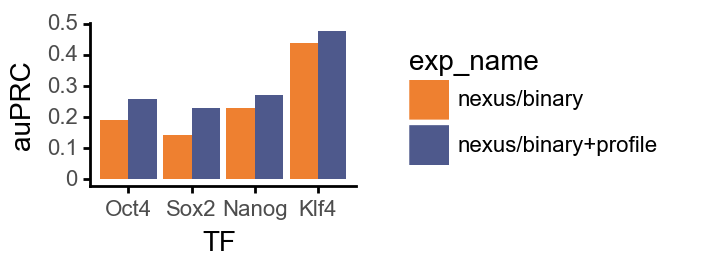

<ggplot: (8770059255602)>

In [17]:
plotnine.options.figure_size = get_figsize(.25)
fig = (ggplot(aes(x='TF', fill='exp_name', y='value'), dfp) + 
       geom_bar(stat='identity', position='dodge') + 
       theme_classic(base_size=10, base_family='Arial') +  \
       scale_fill_manual([colors[x] for x in gw_exp]) + \
       ylab("auPRC") 
      )
fig.save(fdir / 'auPRC.binary-vs-profile+binary.bar.pdf')
fig

### Training time. Binary vs profile

In [18]:
dft = pd.DataFrame([{"training_time": pd.read_csv(f"{models_dir}/{exp}/train.smk-benchmark.tsv", sep='\t').iloc[0]['s'] / 60,
              "Model": model_name,
              "exp": exp}
             for model_name, exp in models.items()])

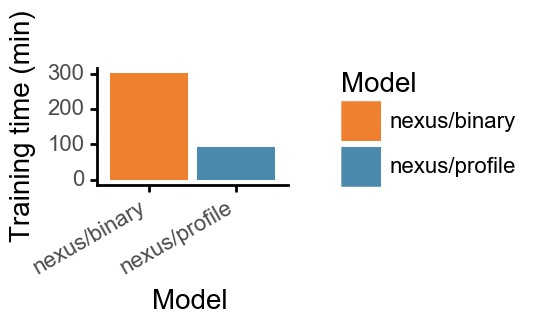

<ggplot: (8770059135012)>

In [19]:
plt_exp = ['nexus/binary', 'nexus/profile']
plotnine.options.figure_size = get_figsize(.18)
fig = (ggplot(aes(x='Model', fill='Model', y='training_time'), dft[dft.Model.isin(plt_exp)]) + 
 geom_bar(stat='identity') + 
 scale_fill_manual([colors[x] for x in plt_exp]) + \
 theme_classic(base_size=10, base_family='Arial') +  \
 xlab("Model") + 
 ylab("Training time (min)") +
 plt9_tilt_xlab(30)
)
fig.save(fdir / 'training-time.bar.pdf')
fig

## Compare the high-quality peak recall

In [16]:
main_motifs = ['Oct4-Sox2', 'Sox2', 'Nanog', 'Klf4']  # NOTE this is a duplication from before

In [17]:
dfi = pd.read_parquet(models_dir / 'dfi_subset.annotated.v3.parq', engine='fastparquet')
dfi = dfi[dfi.example_chrom.isin(test_chr)]  # look at only the test chromosomes
dfi = dfi[dfi.pattern_name.isin(main_motifs)]

In [35]:
# Remove duplicates
dfi = dfi.sort_values("imp_weighted", ascending=False)
duplicated = dfi[['model', 'pattern_name', 'example_chrom', 'pattern_start_abs', 'pattern_end_abs', 'strand']].duplicated()
dfi = dfi[~duplicated]

# setup coordinates
dfi['Chromosome'] = dfi['example_chrom']
dfi['Start'] = dfi['pattern_start_abs']
dfi['End'] = dfi['pattern_end_abs']
dfi['Strand'] = dfi['pattern_end_abs']

In [36]:
import pyranges as pr

In [68]:
def get_profile_score(dfi, score, profile_cls):
    df = dfi[(~dfi[score].isnull())]
    return df.sort_values(score, ascending=False)[profile_cls]

motif_profile_counts = [(motif, 
                         {model: get_profile_score(dfi[(dfi.pattern_name == motif)
                                                       & (dfi.model == model)
                                                       & (dfi.example_chrom.isin(test_chr))
                                                      ],
                                                   'imp_weighted', 
                                                   profile_mapping[motif]+ "/profile_counts_max_ref").values
                         for model in models})
                        for motif in main_motifs]

In [57]:
# Append PWM methods

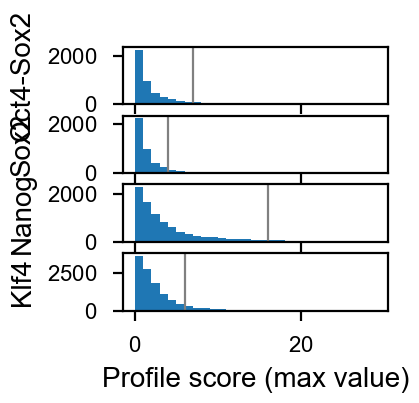

In [58]:
# Profile scores
model = 'nexus/profile'
thresholds = dict()
fig, axes = plt.subplots(len(main_motifs),1,figsize=get_figsize(0.25, 1), sharex=True)
for i, motif in enumerate(main_motifs):
    ax = axes[i]
    scores = motif_profile_counts[i][1][model]
    thresholds[motif] = np.percentile(scores, 90)
    #if len(scores) == 0:
    #    continue
    ax.hist(scores, bins=np.arange(30))
    ax.axvline(thresholds[motif], color='grey')
    ax.set_ylabel(motif)
    if i == len(main_motifs)-1:
        ax.set_xlabel("Profile score (max value)");
    # fig.savefig(fdir / 'profile-score.hist.pdf')

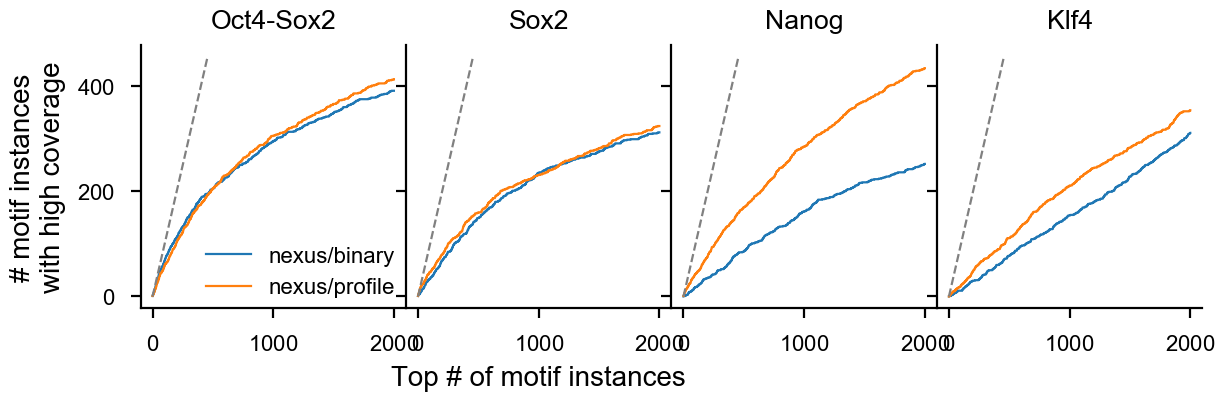

In [40]:
fig, axes = plt.subplots(1, len(main_motifs), figsize=get_figsize(1, 1/(1*len(main_motifs))), 
                         sharex=True, 
                         sharey=True, gridspec_kw=dict(wspace=0, hspace=0))
fig.subplots_adjust(wspace=.5)#, wspace=0)
max_val = 0
for i, (motif, res) in enumerate(motif_profile_counts):
    ax = axes[i]
    # top_n = min([len(x) for x in res.values()])
    top_n = 2000
    for k,v in res.items():
        if k in ['nexus/profile', 'nexus/binary']:
            cutoff = thresholds[motif]
            ax.plot(np.cumsum(v[:top_n] > cutoff), label=k)

    max_val = max(max_val, ax.get_ylim()[1])
    if i == 0:
        ax.set_ylabel("# motif instances\nwith high coverage")
    if i == 1:
        ax.set_xlabel("Top # of motif instances")
    if i == 0:
        leg = ax.legend(loc='lower right', framealpha=1, borderpad=0)
        leg.get_frame().set_linewidth(0.0)
    ax.set_title(motif)

for i, (motif, res) in enumerate(motif_profile_counts):
    axes[i].plot([0, max_val], [0, max_val], '--', color='grey', label=None)
sns.despine(top=True, right=True)    
fig.savefig(fdir / 'profile-recall.nexus.profile-vs-binary.pdf')

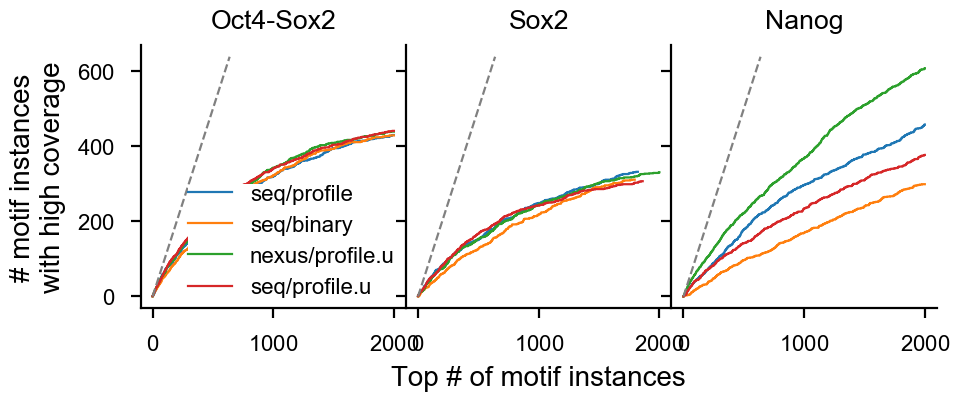

In [41]:
fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(0.75, 1/(1*len(main_motifs)-1)), 
                         sharex=True, 
                         sharey=True, gridspec_kw=dict(wspace=0, hspace=0))
# fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(.75, 1/(1*len(main_motifs)-1)), 
#                          sharex=True, 
#                          sharey=True, gridspec_kw=dict(wspace=0, hspace=0))

fig.subplots_adjust(wspace=.5)#, wspace=0)
max_val = 0
for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    ax = axes[i]
    # top_n = min([len(x) for x in res.values()])
    top_n = 2000
    for k,v in res.items():
        if k in ['nexus/profile.peaks-union', 'seq/profile', 'seq/profile.peaks-union', 'seq/binary']:
            cutoff = thresholds[motif]
            ax.plot(np.cumsum(v[:top_n] > cutoff), label=k.replace("peaks-union", 'u'))

    max_val = max(max_val, ax.get_ylim()[1])
    if i == 0:
        ax.set_ylabel("# motif instances\nwith high coverage")
    if i == 1:
        ax.set_xlabel("Top # of motif instances")
    if i == 0:
        leg = ax.legend(loc='bottom right', framealpha=1, borderpad=0)
        leg.get_frame().set_linewidth(0.0)
    ax.set_title(motif)

for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    axes[i].plot([0, max_val], [0, max_val], '--', color='grey', label=None)
sns.despine(top=True, right=True)   
fig.savefig(fdir / 'profile-recall.nexus-vs-seq.pdf')

## Plots with PWM

### Get motif instances for BPNet-PWM scan

Just use the motifs from the Fimo scan from ChIP-nexus data 

In [42]:
from basepair.utils import read_pkl
dfi_list_chipseq = read_pkl("/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/chexmix-peakxus/dfi_list.chipseq.pkl")
closest_motifs = read_pkl("/oak/stanford/groups/akundaje/avsec/basepair/data/processed/comparison/chexmix-peakxus/closest_motifs.pkl")
# dfi_list_ChIP_seq[f'MEME/FIMO-{ranges_name}'] = {"name": 'MEME/FIMO',
#                                                  "dfi": dfi_meme_annotated,
#                                                  "score": "score",
#                                                  "ranges_name": ranges_name,
#                                                  "motif_method": "MEME"}

In [43]:
list(dfi_list_chipseq)

['MEME/FIMO-chip-seq', 'MEME/FIMO-chip-seq,nexus']

In [44]:
dfi_list_chipseq['MEME/FIMO-chip-seq']['dfi'].pattern_name

0         Oct4/3
1         Oct4/2
2         Oct4/2
           ...  
647845    Klf4/3
647846    Klf4/3
647847    Klf4/3
Name: pattern_name, Length: 647266, dtype: object

In [69]:
for motif, model_counts_dict in motif_profile_counts:
    if motif == 'Klf4':
        # Exclude Klf4 motif.
        continue
    for method, v in dfi_list_chipseq.items():
        model_counts_dict[method] = get_profile_score(v['dfi'][(v['dfi'].pattern_name == (motif if v['motif_method'] == 'BPNet' 
                                                                                          else closest_motifs[motif][v['motif_method']][0].name))
                                                               & (v['dfi'].example_chrom.isin(test_chr))
                                                               # & ((v['dfi'].pattern_center - 500).abs() < max_diff)
                                                              ],
                                                      v['score'],
                                                      profile_mapping[motif]+ "/counts_max_ref"
                                                      ).values

In [46]:
list(dfi_list_chipseq)

['MEME/FIMO-chip-seq', 'MEME/FIMO-chip-seq,nexus']

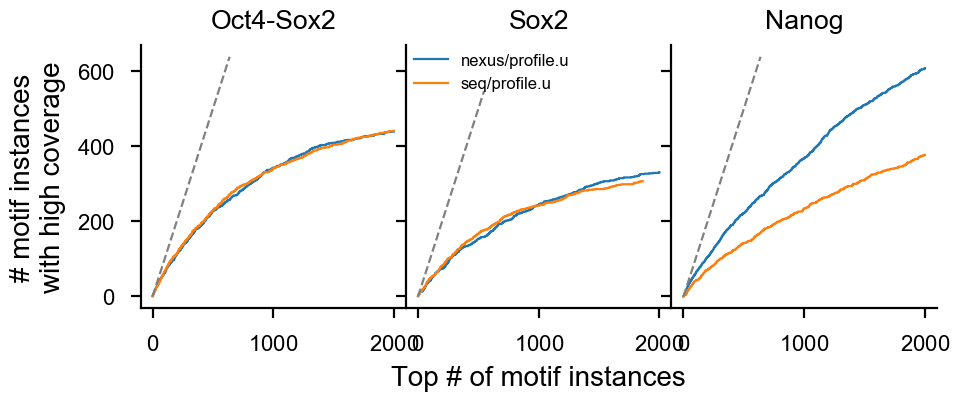

In [70]:
fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(0.75, 1/(1*len(main_motifs)-1)), 
                         sharex=True, 
                         sharey=True, gridspec_kw=dict(wspace=0, hspace=0))
# fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(.75, 1/(1*len(main_motifs)-1)), 
#                          sharex=True, 
#                          sharey=True, gridspec_kw=dict(wspace=0, hspace=0))

fig.subplots_adjust(wspace=.5)#, wspace=0)
max_val = 0
for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    ax = axes[i]
    # top_n = min([len(x) for x in res.values()])
    top_n = 2000
    for k,v in res.items():
        if k in ['nexus/profile.peaks-union', 'seq/profile.peaks-union']:
            cutoff = thresholds[motif]
            ax.plot(np.cumsum(v[:top_n] > cutoff), label=k.replace("peaks-union", 'u'))

    max_val = max(max_val, ax.get_ylim()[1])
    if i == 0:
        ax.set_ylabel("# motif instances\nwith high coverage")
    if i == 1:
        ax.set_xlabel("Top # of motif instances")
    if i == 1:
        leg = ax.legend(loc='upper left', framealpha=1, borderpad=0, prop={'size': 6})
        leg.get_frame().set_linewidth(0.0)
    ax.set_title(motif)

for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    axes[i].plot([0, max_val], [0, max_val], '--', color='grey', label=None)
sns.despine(top=True, right=True)   
fig.savefig(fdir / f'profile-recall.nexus-vs-seq-only.whole-1kb.pdf')

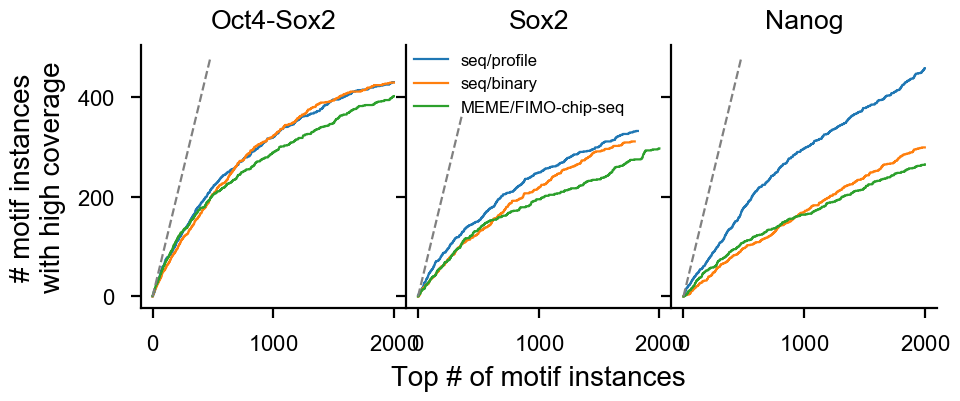

In [71]:
fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(0.75, 1/(1*len(main_motifs)-1)), 
                         sharex=True, 
                         sharey=True, gridspec_kw=dict(wspace=0, hspace=0))
# fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(.75, 1/(1*len(main_motifs)-1)), 
#                          sharex=True, 
#                          sharey=True, gridspec_kw=dict(wspace=0, hspace=0))

fig.subplots_adjust(wspace=.5)#, wspace=0)
max_val = 0
for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    ax = axes[i]
    # top_n = min([len(x) for x in res.values()])
    top_n = 2000
    for k,v in res.items():
        if k in ['seq/profile', 'seq/binary','MEME/FIMO-chip-seq']:
            cutoff = thresholds[motif]
            ax.plot(np.cumsum(v[:top_n] > cutoff), label=k.replace("peaks-union", 'u'))

    max_val = max(max_val, ax.get_ylim()[1])
    if i == 0:
        ax.set_ylabel("# motif instances\nwith high coverage")
    if i == 1:
        ax.set_xlabel("Top # of motif instances")
    if i == 1:
        leg = ax.legend(loc='upper left', framealpha=1, borderpad=0, prop={'size': 6})
        leg.get_frame().set_linewidth(0.0)
    ax.set_title(motif)

for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    axes[i].plot([0, max_val], [0, max_val], '--', color='grey', label=None)
sns.despine(top=True, right=True)   
fig.savefig(fdir / f'profile-recall.chip-seq.profile-vs-binary-vs-pwm.whole-1kp.pdf')

## Only the central 200 bp

In [72]:
max_diff = 100

def get_profile_score(dfi, score, profile_cls):
    df = dfi[(~dfi[score].isnull())]
    return df.sort_values(score, ascending=False)[profile_cls]

motif_profile_counts = [(motif, 
                         {model: get_profile_score(dfi[(dfi.pattern_name == motif)
                                                       & (dfi.model == model)
                                                       & (dfi.example_chrom.isin(test_chr))
                                                       & ((dfi.pattern_center - 500).abs() < max_diff)
                                                      ],
                                                   'imp_weighted', 
                                                   profile_mapping[motif]+ "/profile_counts_max_ref").values
                         for model in models})
                        for motif in main_motifs]

for motif, model_counts_dict in motif_profile_counts:
    if motif == 'Klf4':
        # Exclude Klf4 motif.
        continue
    for method, v in dfi_list_chipseq.items():
        model_counts_dict[method] = get_profile_score(v['dfi'][(v['dfi'].pattern_name == (motif if v['motif_method'] == 'BPNet' 
                                                                                          else closest_motifs[motif][v['motif_method']][0].name))
                                                               & (v['dfi'].example_chrom.isin(test_chr))
                                                               & ((v['dfi'].pattern_center - 500).abs() < max_diff)
                                                              ],
                                                      v['score'],
                                                      profile_mapping[motif]+ "/counts_max_ref"
                                                      ).values

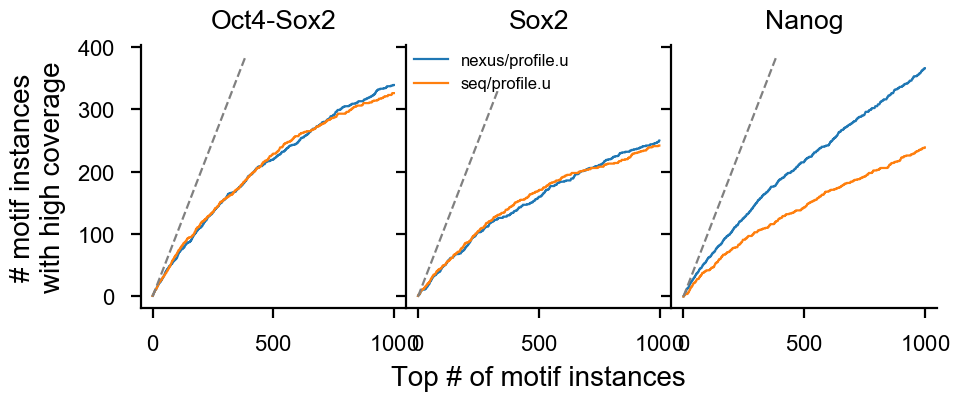

In [74]:
fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(0.75, 1/(1*len(main_motifs)-1)), 
                         sharex=True, 
                         sharey=True, gridspec_kw=dict(wspace=0, hspace=0))
# fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(.75, 1/(1*len(main_motifs)-1)), 
#                          sharex=True, 
#                          sharey=True, gridspec_kw=dict(wspace=0, hspace=0))

fig.subplots_adjust(wspace=.5)#, wspace=0)
max_val = 0
for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    ax = axes[i]
    # top_n = min([len(x) for x in res.values()])
    top_n = 1000
    for k,v in res.items():
        if k in ['nexus/profile.peaks-union', 'seq/profile.peaks-union']:
            cutoff = thresholds[motif]
            ax.plot(np.cumsum(v[:top_n] > cutoff), label=k.replace("peaks-union", 'u'))

    max_val = max(max_val, ax.get_ylim()[1])
    if i == 0:
        ax.set_ylabel("# motif instances\nwith high coverage")
    if i == 1:
        ax.set_xlabel("Top # of motif instances")
    if i == 1:
        leg = ax.legend(loc='upper left', framealpha=1, borderpad=0, prop={'size': 6})
        leg.get_frame().set_linewidth(0.0)
    ax.set_title(motif)

for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    axes[i].plot([0, max_val], [0, max_val], '--', color='grey', label=None)
sns.despine(top=True, right=True)   
fig.savefig(fdir / f'profile-recall.nexus-vs-seq-only.central-{2*max_diff}bp.pdf')

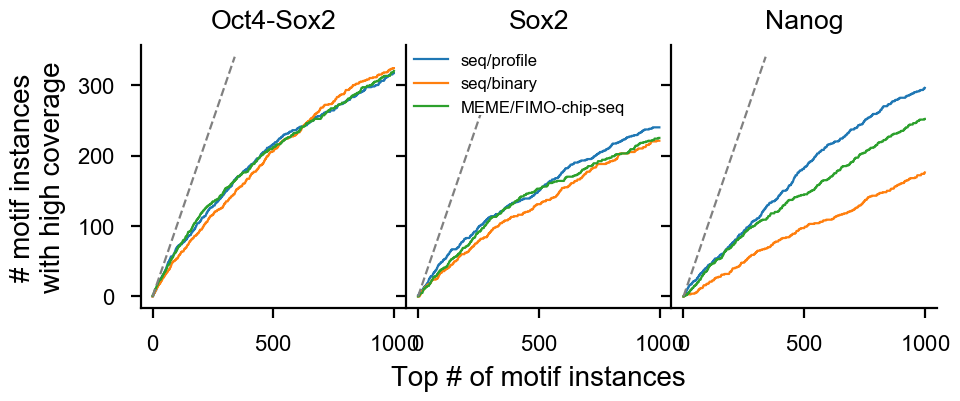

In [75]:
fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(0.75, 1/(1*len(main_motifs)-1)), 
                         sharex=True, 
                         sharey=True, gridspec_kw=dict(wspace=0, hspace=0))
# fig, axes = plt.subplots(1, len(main_motifs)-1, figsize=get_figsize(.75, 1/(1*len(main_motifs)-1)), 
#                          sharex=True, 
#                          sharey=True, gridspec_kw=dict(wspace=0, hspace=0))

fig.subplots_adjust(wspace=.5)#, wspace=0)
max_val = 0
for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    ax = axes[i]
    # top_n = min([len(x) for x in res.values()])
    top_n = 1000
    for k,v in res.items():
        if k in ['seq/profile', 'seq/binary','MEME/FIMO-chip-seq']:
            cutoff = thresholds[motif]
            ax.plot(np.cumsum(v[:top_n] > cutoff), label=k.replace("peaks-union", 'u'))

    max_val = max(max_val, ax.get_ylim()[1])
    if i == 0:
        ax.set_ylabel("# motif instances\nwith high coverage")
    if i == 1:
        ax.set_xlabel("Top # of motif instances")
    if i == 1:
        leg = ax.legend(loc='upper left', framealpha=1, borderpad=0, prop={'size': 6})
        leg.get_frame().set_linewidth(0.0)
    ax.set_title(motif)

for i, (motif, res) in enumerate(motif_profile_counts[:-1]):
    axes[i].plot([0, max_val], [0, max_val], '--', color='grey', label=None)
sns.despine(top=True, right=True)   
fig.savefig(fdir / f'profile-recall.chip-seq.profile-vs-binary-vs-pwm.central-{2*max_diff}bp.pdf')